In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cv2
from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
path = untar_data("")
path.ls()

[PosixPath('/home/sahand/Smoke_detection/data/smoke'),
 PosixPath('/home/sahand/Smoke_detection/data/Examples_DST3_Dataset'),
 PosixPath('/home/sahand/Smoke_detection/data/labels.csv'),
 PosixPath('/home/sahand/Smoke_detection/data/Synth_Smoke_Frame_Classification'),
 PosixPath('/home/sahand/Smoke_detection/data/models'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation'),
 PosixPath('/home/sahand/Smoke_detection/data/TTG TUR'),
 PosixPath('/home/sahand/Smoke_detection/data/stage-2.pth'),
 PosixPath('/home/sahand/Smoke_detection/data/omdena_data')]

In [3]:
image_path = path/'TTG TUR/TTG TUR'
smoke_path = path/'smoke'
print(image_path)

image_paths = glob.glob(os.path.join(image_path,'*.jpeg'))  
smoke_paths = glob.glob(os.path.join(smoke_path,'*.jpg'))

/home/sahand/Smoke_detection/data/TTG TUR/TTG TUR


In [4]:
data = []

for image_path in image_paths:
    
    label_name = image_path.split('.jpeg')[0][-3:]
    image_path=image_path[34:]
    
    label = -1
    
    if label_name == 'SIM':
        label = 1
    elif label_name == 'NAO':
        label = 0
    
    data.append((image_path, label))

In [5]:

for smoke in smoke_paths :
    smoke= smoke[34:]

    data.append((smoke, 1))

In [6]:
    
labels = pd.DataFrame(data)
labels.to_csv(path/'labels.csv', index=False)

In [7]:
image_path = path/'TTG TUR/TTG TUR'

labels_path=path/'labels.csv'
labels =pd.read_csv(labels_path)

In [8]:
labels.head()

,0,1
0,TTG TUR/TTG TUR/2018-03-04 09-07-10_NAO.jpeg,0
1,TTG TUR/TTG TUR/2018-03-14 10-07-31_NAO.jpeg,0
2,TTG TUR/TTG TUR/2018-03-04 11-26-57_NAO.jpeg,0
3,TTG TUR/TTG TUR/2018-03-20 09-38-56_NAO.jpeg,0
4,TTG TUR/TTG TUR/2018-03-20 09-27-27_NAO.jpeg,0


In [9]:
bs= 32
data = ImageList.from_df(labels, path).split_by_rand_pct().label_from_df().transform(get_transforms(), size=256).databunch(bs=bs).normalize(imagenet_stats)  


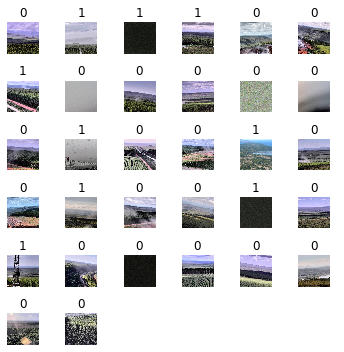

In [10]:
data.show_batch(rows=10, figsize=(5,5))


In [11]:
class Precision(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==0) * (last_target==0)).float().sum()
        self.total += (preds==0).float().sum()
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.correct/self.total)
    
class AUROC(Callback):
    "Computes the area under the curve (AUC) score based on the receiver operator characteristic (ROC) curve. Restricted to binary classification tasks."
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = LongTensor([]), Tensor([])
        
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = F.softmax(last_output, dim=1)[:,-1]
        self.preds = torch.cat((self.preds, last_output.cpu()))
        self.targs = torch.cat((self.targs, last_target.cpu().long()))
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, auc_roc_score(self.preds, self.targs))

In [12]:

learn = cnn_learner(data, models.resnet50, metrics=[accuracy, Precision(), AUROC()], callback_fns=ShowGraph)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


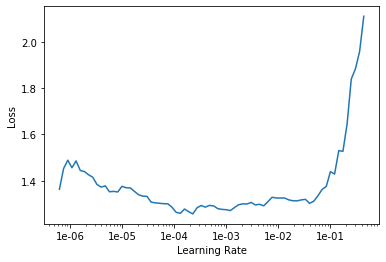

In [13]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision,auroc,time
0,1.085096,0.836069,0.679365,0.833548,0.711939,01:16
1,0.895638,0.652990,0.729365,0.826577,0.726032,01:15
2,0.764144,0.556343,0.747619,0.792435,0.726176,01:15
3,0.590643,0.509001,0.746032,0.789778,0.748439,01:15
4,0.574069,0.492964,0.772222,0.827479,0.767897,01:15
5,0.531301,0.490500,0.771429,0.793327,0.758439,01:15
6,0.516964,0.477048,0.784921,0.824351,0.774085,01:15
7,0.489880,0.485709,0.773810,0.805769,0.769460,01:15
8,0.484285,0.483673,0.779365,0.829069,0.788325,01:15
9,0.471615,0.485006,0.782540,0.834540,0.785596,01:15


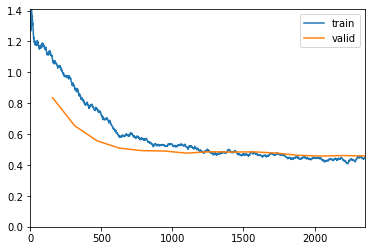

In [14]:
learn.fit_one_cycle(15,slice(1e-3))


In [15]:
learn.save('stage-1-50')


In [16]:
learn.unfreeze()


epoch,train_loss,valid_loss,accuracy,precision,auroc,time
0,0.444080,0.450939,0.792857,0.830000,0.803615,01:15
1,0.447602,0.453056,0.796032,0.825490,0.808103,01:15
2,0.445905,0.472967,0.800000,0.831516,0.791118,01:15
3,0.428931,0.455476,0.800000,0.812325,0.810367,01:16
4,0.379976,0.483524,0.796032,0.826130,0.808525,01:18
5,0.381050,0.476728,0.791270,0.850746,0.823175,01:18
6,0.346902,0.454480,0.798413,0.851423,0.834472,01:17
7,0.303622,0.477711,0.807936,0.852544,0.829520,01:19
8,0.288176,0.478324,0.811111,0.849539,0.830292,01:17
9,0.280414,0.485016,0.809524,0.859556,0.831653,01:18


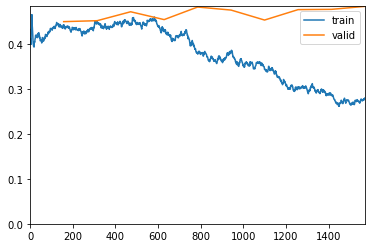

In [17]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3))


In [18]:
learn.save('stage-1-50')


In [19]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

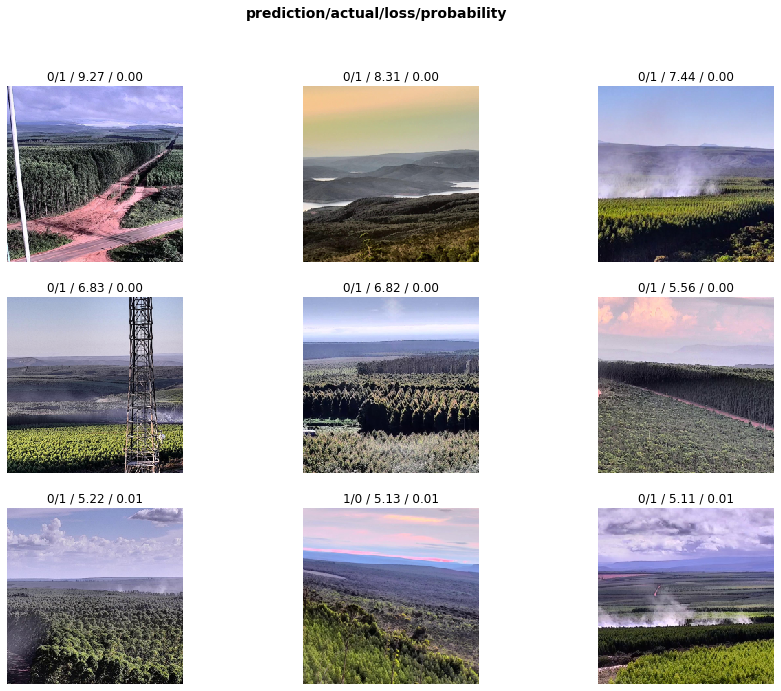

In [20]:
interp.plot_top_losses(9, figsize=(15,11))


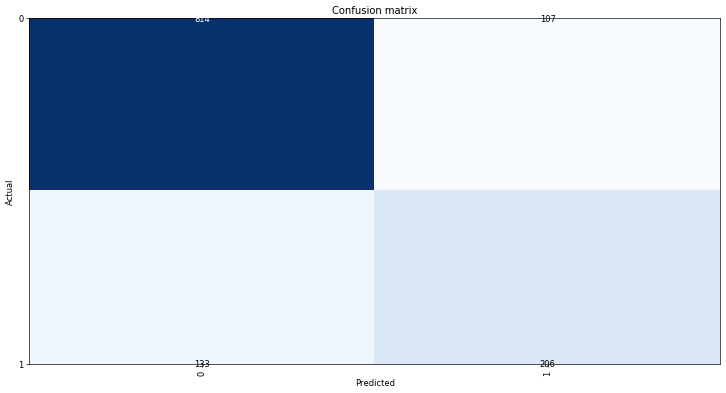

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [24]:
learn.save('stage-1-50')
